# 2. Compress training SED data 

In [ ]:
import os
import numpy as np

In [2]:
from sklearn.decomposition import PCA, IncrementalPCA

In [3]:
import util as U

In [4]:
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False


Bad key text.latex.preview in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95 

# wavelength chunks

In [5]:
wave_bins = [(1.5e3, 3.525e3), 
             (3.525e3, 5.5e3), (5.5e3, 7.5e3), # these wavelength ranges are determined by the MILES spectral library wavelength (3525 - 7500)
             (7.5e3, 4e5)]
n_pcas = [50, 50, 30, 30]

# read wavelengths and fluxes 

In [6]:
_w = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.0.waves.npz'))['arr_0'][0]

logseds = [] 
for seed in [0]:#range(10):
    logseds.append(np.log10(np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.%i.seds.npz' % seed))['arr_0']))
logseds = np.concatenate(logseds)

(1500.0, 400000.0)

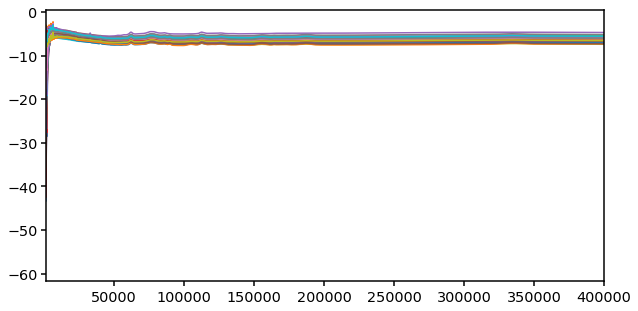

In [7]:
fig = plt.figure(figsize=(10, 5))
sub = fig.add_subplot(111)
for _i in np.arange(logseds.shape[0])[::1000]: 
    sub.plot(_w, logseds[_i])
sub.set_xlim(1.5e3, 4e5)

175 spectral elements


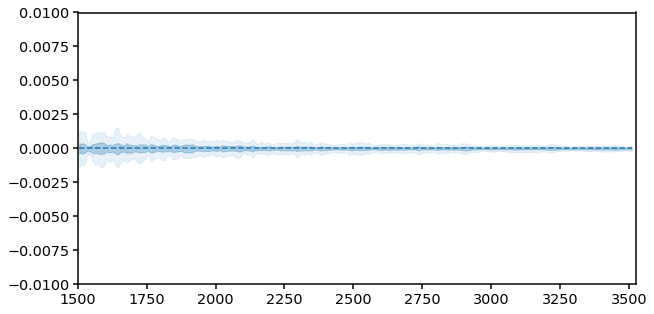

2113 spectral elements


In [ ]:
for ii, n_pca, wave_bin in zip(np.range(len(wave_bins)), n_pcas, wave_bins):
    wlim = np.ones(len(_w)).astype(bool)
    if wave_bin[0] is not None: wlim &= (_w > wave_bin[0])
    if wave_bin[1] is not None: wlim &= (_w < wave_bin[1])    
    print('%i spectral elements' % np.sum(wlim))
    
    logseds = [] 
    for seed in range(10):
        logseds.append(np.log10(np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.%i.seds.npz' % seed))['arr_0'][:,wlim]))
    logseds = np.concatenate(logseds)
    
    #fig = plt.figure(figsize=(10, 5))
    #sub = fig.add_subplot(111)
    #for _i in range(10): 
    #    sub.plot(_w[wlim], 10**logseds[_i])
    #sub.set_xlim(wave_bin)
    
    # whiten logseds
    avg_logseds = np.mean(logseds, axis=0)
    std_logseds = np.std(logseds, axis=0)
    np.save(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.avg_logseds.w%i.npy' % ii), avg_logseds)
    np.save(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.std_logseds.w%i.npy' % ii), std_logseds)            
    
    logseds -= avg_logseds
    logseds /= std_logseds

    pca = IncrementalPCA(n_components=n_pca, batch_size=10000)
    x_pca = pca.fit_transform(logseds)

    M_pca = pca.components_
    np.save(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.M_pca.w%i.npy' % ii), M_pca)
    np.save(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.x_pca.w%i.npy' % ii), x_pca)    
    
    # validation
    logseds_pca = np.dot(x_pca, M_pca)
    
    dsed = 10**(logseds * std_logseds + avg_logseds) - 10**(logseds_pca * std_logseds + avg_logseds)
    
    fig = plt.figure(figsize=(10, 5))
    sub = fig.add_subplot(111)
    #for _i in range(10): 
    #    sub.plot(_w[wlim], dsed[_i]/10**(logseds[_i] * std_logseds + avg_logseds))
    q0, q1, q2, q3 = np.quantile(dsed/10**(logseds * std_logseds + avg_logseds), [0.025, 0.16, 0.84, 0.975], axis=0)
    sub.fill_between(_w[wlim], q0, q3, color='C0', alpha=0.1)    
    sub.fill_between(_w[wlim], q1, q2, color='C0', alpha=0.3)  
    sub.plot(_w[wlim], np.zeros(np.sum(wlim)), c='C0', ls='--')
    sub.set_xlim(wave_bin)
    sub.set_ylim(-0.01, 0.01)
    plt.show()

In [ ]:
np.max(logseds - np.dot(x_pca, pca.components_))